In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/liveness_detection

/content/drive/MyDrive/liveness_detection


In [ ]:
pwd

'/content/drive/MyDrive/liveness_detection'

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

2024-11-30 15:05:37.397300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732953937.500787   49088 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732953937.529897   49088 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 15:05:37.693093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  1


In [5]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [ ]:
# Direktori dataset
DATASET_DIR = "../datasets/datasets/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
TRAIN_SET = os.path.join(DATASET_DIR, "train_looking_left_set")
TEST_SET = os.path.join(DATASET_DIR, "test_looking_left_set")

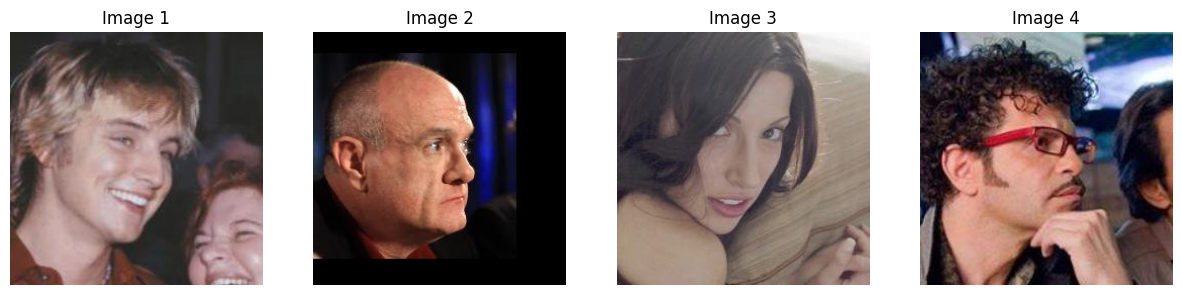

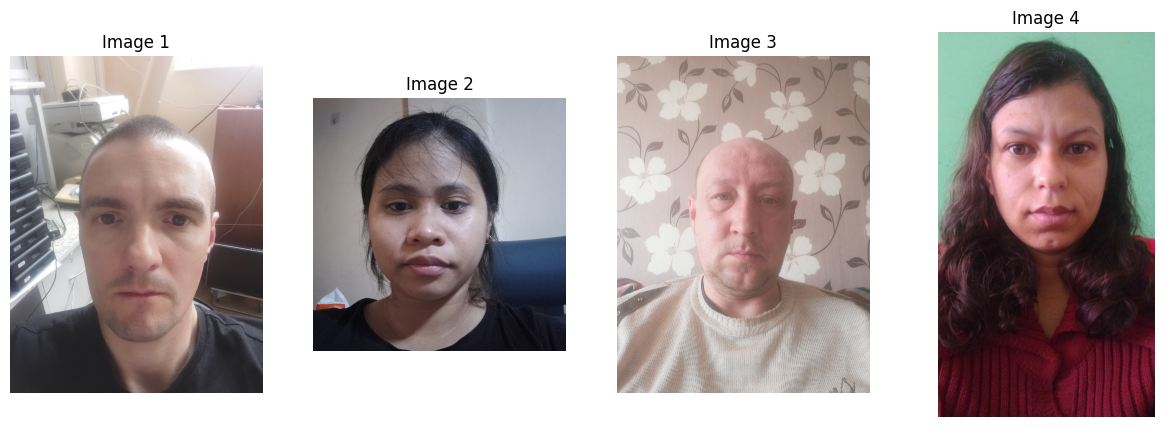

In [6]:
# Fungsi untuk menampilkan gambar
def show_images(directory, num_images=5):
  """Menampilkan beberapa gambar dari direktori yang diberikan.

  Args:
    directory: Path ke direktori yang berisi gambar.
    num_images: Jumlah gambar yang akan ditampilkan.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  fig, axes = plt.subplots(1, min(num_images, len(image_files)), figsize=(15, 5))
  for i, ax in enumerate(axes):
      if i < len(image_files):
          image_path = os.path.join(directory, image_files[i])
          img = mpimg.imread(image_path)
          ax.imshow(img)
          ax.axis('off')
          ax.set_title(f"Image {i+1}")
  plt.show()

# Menampilkan 4 gambar dari direktori "real" dalam dataset
left = os.path.join(TRAIN_SET, "left")
show_images(left, num_images=4)

# Menampilkan 4 gambar dari direktori "fake" dalam dataset
front_facing = os.path.join(TRAIN_SET, "front_facing")
show_images(front_facing, num_images=4)


In [ ]:
# # Ambil path ke gambar di setiap folder
# attack_path = os.path.join(DATASET_DIR, 'attack')
# liveness_path = os.path.join(DATASET_DIR, 'liveness')

# # Ambil 2 gambar dari setiap folder
# attack_images = [train_data.filepaths[i] for i in range(len(train_data.filepaths)) if train_data.filepaths[i].startswith(attack_path)][0:2]
# liveness_images = [train_data.filepaths[i] for i in range(len(train_data.filepaths)) if train_data.filepaths[i].startswith(liveness_path)][0:2]

# # Gabungkan gambar dari kedua folder
# original_image_paths = attack_images + liveness_images

# # Load dan tampilkan gambar original
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# for i, img_path in enumerate(original_image_paths):
#     img = plt.imread(img_path)
#     axes[i].imshow(img)
#     axes[i].set_title(f"Original Image {i+1} ({'attack' if i < 2 else 'liveness'})")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

In [8]:
# Pilih satu gambar secara acak dari direktori attack dan liveness
left_dir = os.path.join(TRAIN_SET, 'left')
front_facing_dir = os.path.join(TRAIN_SET, 'front_facing')

left_images = [os.path.join(left_dir, f) for f in os.listdir(left_dir) if os.path.isfile(os.path.join(left_dir, f))]
front_facing_images = [os.path.join(front_facing_dir, f) for f in os.listdir(front_facing_dir) if os.path.isfile(os.path.join(front_facing_dir, f))]

random_attack_image_path = random.choice(left_images)
random_liveness_image_path = random.choice(front_facing_images)

image_paths = [random_attack_image_path, random_liveness_image_path]

In [9]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi untuk melakukan cropping pada gambar
def crop_center(image, cropx, cropy):
    y, x, _ = image.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return image[starty:starty+cropy, startx:startx+cropx]

# Fungsi preprocessing yang menggabungkan cropping dan preprocessing MobileNetV3
def preprocess_and_crop(image):
    image = img_to_array(image)
    image = crop_center(image, 224, 224)
    image = preprocess_input(image)
    return image

In [10]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_crop,
    validation_split=0.2,
    brightness_range=[0.7, 1.3],
    # horizontal_flip=True,
    # vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    fill_mode='nearest',
    channel_shift_range=0.2
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_and_crop)

train_generator = train_datagen.flow_from_directory(
    TRAIN_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1524 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


ValueError: could not broadcast input array from shape (22,42,3) into shape (180,141,3)

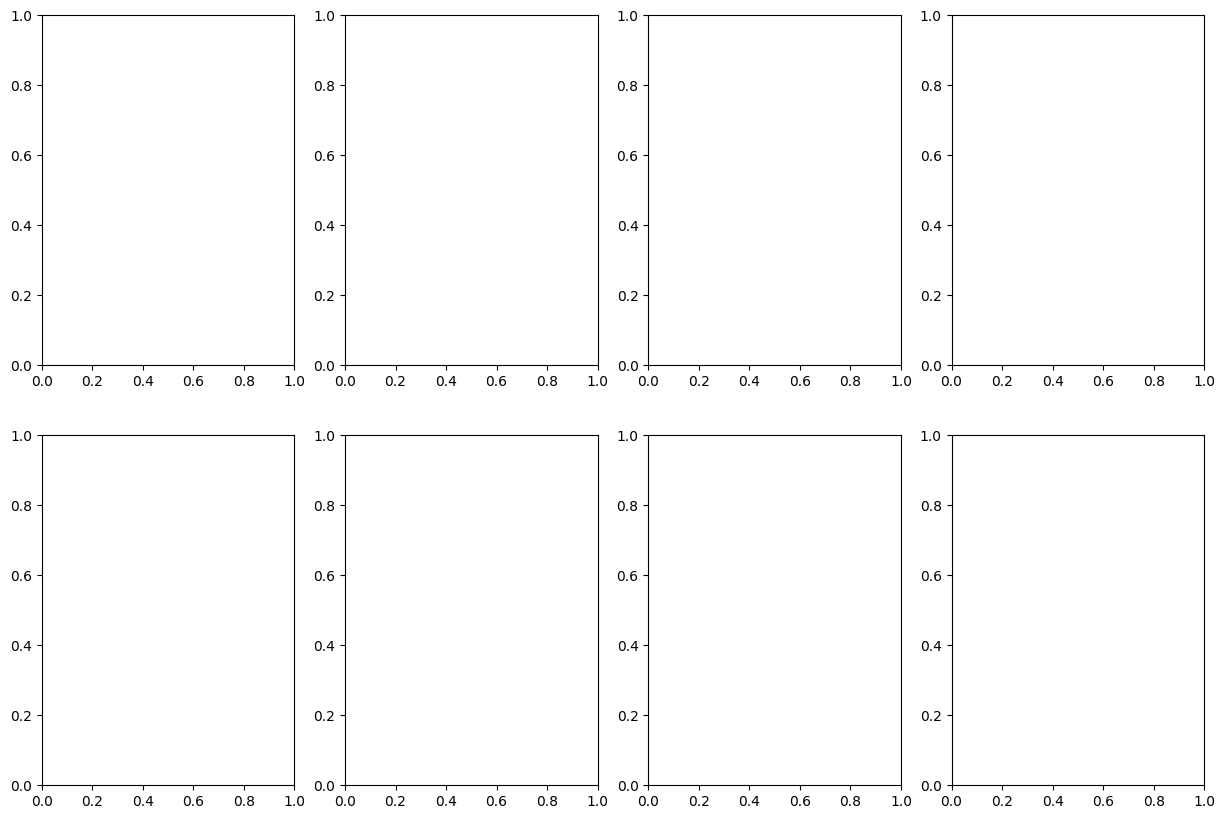

In [12]:
# Load dan augmentasi gambar
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i, img_path in enumerate(image_paths):
  img = load_img(img_path)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  # Buat ImageDataGenerator untuk augmentasi
  datagen = train_datagen

  # Generate gambar augmentasi
  augmented_images = [next(datagen.flow(x, batch_size=1))[0] for _ in range(3)]

  # Tampilkan gambar original dan augmentasi
  axes[i, 0].imshow(img)
  axes[i, 0].set_title(f"Original Image {i+1} ({'opened_eyes' if i == 0 else 'closed_eyes'})")
  axes[i, 0].axis('off')

  for j, augmented_image in enumerate(augmented_images):
    axes[i, j+1].imshow(augmented_image.astype('uint8'))
    axes[i, j+1].set_title(f"Augmented Image {j+1}")
    axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Model Transfer Learning dengan EfficientNetB_

# from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
x = MaxPooling2D(2, 2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

I0000 00:00:1732954451.378128   49088 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None:
            if acc >= 0.99 and val_acc >= 0.98999:
                print("\nReached target accuracy, stopping training...")
                self.model.stop_training = True

In [20]:
# Callback
checkpoint_path = "../model_downlaod/looking_left/model_looking_left_4.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# custom_callback = CustomCallback()

In [21]:
# Training
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint,
               early_stopping,
              #  custom_callback,
               lr_scheduler]
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - Precision: 0.9813 - Recall: 0.9795 - accuracy: 0.9806 - loss: 0.2871
Epoch 1: val_accuracy improved from -inf to 0.98084, saving model to ../model_downlaod/looking_left/model_looking_left_4.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - Precision: 0.9813 - Recall: 0.9796 - accuracy: 0.9807 - loss: 0.2869 - val_Precision: 1.0000 - val_Recall: 0.9617 - val_accuracy: 0.9808 - val_loss: 0.2797 - learning_rate: 2.0000e-05
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - Precision: 0.9825 - Recall: 0.9711 - accuracy: 0.9763 - loss: 0.2695
Epoch 2: val_accuracy did not improve from 0.98084
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - Precision: 0.9826 - Recall: 0.9712 - accuracy: 0.9764 - loss: 0.2695 - val_Precision: 1.0000 - val_Recall: 0.9617 - val_accuracy: 0.9808 - val_loss: 0.2764 - learning_rate: 2.0000e-05
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - Precision: 0.9908 - Recall: 0.9797 - accuracy: 0.9858 - loss: 0.2577
Epo

In [25]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 770ms/step - Precision: 0.9963 - Recall: 0.9685 - accuracy: 0.9818 - loss: 0.2407
Loss: 0.23926514387130737, Accuracy: 0.982758641242981, Precision: 0.9960629940032959, Recall: 0.969348669052124


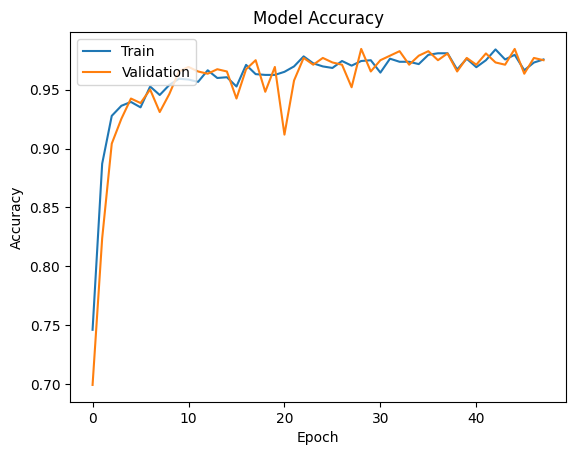

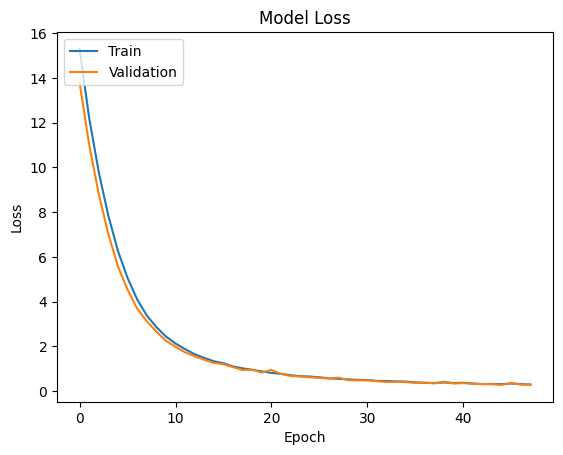

In [18]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Mendapatkan prediksi dari model pada data validasi
y_pred = model.predict(val_data)
y_pred_classes = np.round(y_pred)

# Mendapatkan label sebenarnya dari data validasi
y_true = val_data.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualisasi confusion matrix (opsional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Attack', 'Liveness'], yticklabels=['Attack', 'Liveness'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'val_data' is not defined

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('../datasets/pictures/model_download/model_looking_left.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Example usage:
test_image_path = "/content/drive/MyDrive/liveness_detection/datasets/test/0001_00_01_03_77.jpg" # Replace with the path to your test image

preprocessed_image = preprocess_image(test_image_path)
prediction = model.predict(preprocessed_image)

if prediction[0][0] > 0.5:
  print("Prediction: Liveness")
else:
  print("Prediction: Attack")

# You can also get the confidence score
print(f"Confidence score: {prediction[0][0]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: Attack
Confidence score: 0.0002683894126676023


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction: Looking Left
Confidence score: 0.9998


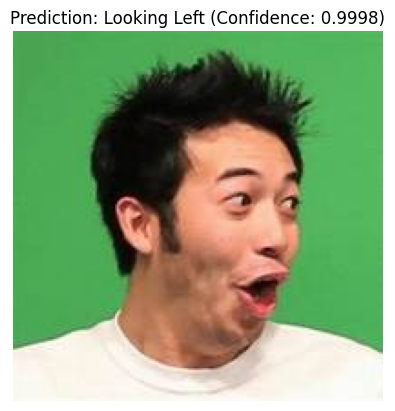

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Front Facing
Confidence score: 0.9998


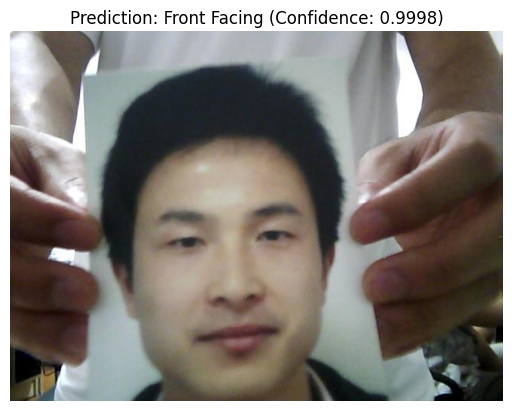

In [24]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/looking_left/model_looking_left_4_.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Function to predict and display results
def predict_image(image_path):
  preprocessed_image = preprocess_image(image_path)
  prediction = model.predict(preprocessed_image)

  if prediction[0][0] > 0.5:
    label = "Looking Left"
  else:
    label = "Front Facing"

  confidence = prediction[0][0] if label == "Looking Left" else 1 - prediction[0][0]

  print(f"Prediction: {label}")
  print(f"Confidence score: {confidence:.4f}")
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
  plt.axis('off')
  plt.show()


# Example usage:
test_image_path1 = "../datasets/test/test/left.jpeg"
test_image_path2 = "../datasets/test/test/0001_00_01_03_77.jpg"


predict_image(test_image_path1)
predict_image(test_image_path2)


In [ ]:
# COnvert to tflite

model = tf.keras.models.load_model('../datasets/pictures/model_download/model_blink.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert()

tflite_model_path = '../datasets/pictures/model_download/model_blink.tflite' 
with open(tflite_model_path, 'wb') as f: 
    f.write(tflite_model) 
    
print(f"Model converted and saved to {tflite_model_path}")

In [26]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/front_facing/model_front_facing4.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/looking_left/model_looking_left_quant4.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmpggbjreja/assets


INFO:tensorflow:Assets written to: /tmp/tmpggbjreja/assets


Saved artifact at '/tmp/tmpggbjreja'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140250192561952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192572336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192574448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192567760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192570048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192663072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192663248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192667472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192664832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250192665536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1402501926709

W0000 00:00:1732959294.906433   49088 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732959294.908447   49088 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-30 16:34:54.912832: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpggbjreja
2024-11-30 16:34:54.920084: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-30 16:34:54.920121: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpggbjreja
I0000 00:00:1732959294.992619   49088 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-30 16:34:55.007281: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-30 16:34:55.476062: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpggbjreja
2024-11-30 16:34:55.613266: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Model TFLite dengan kuantisasi rentang dinamis telah disimpan.
